In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns

In [2]:
def collect_losses(root_dir):

    depth = 2

    dict_res_roberta = dict()
    dict_res_camem = dict()
    dict_res_xlm = dict()
    
    for subdir, dirs, files in os.walk(root_dir):
        if subdir[len(root_dir):].count(os.sep) < depth:
            for file_ in files:
                if file_ == "finetuning_results.json":
                    with open(subdir + "/" + file_) as f:
                        d = json.load(f)
                        losses_ts = d["losses_ts"]
                    model_type = subdir.split(os.sep)[-1].split("_")[-1]
                    if model_type == "roberta":
                        dataset_name = "_".join(subdir.split(os.sep)[-1].split("_")[2:-1])
                        dict_res_roberta[dataset_name] = losses_ts
                    elif model_type == "xlm":
                        dataset_name = "_".join(subdir.split(os.sep)[-1].split("_")[2:-1])
                        dict_res_xlm[dataset_name] = losses_ts
                    elif model_type == "camem":
                        dataset_name = "_".join(subdir.split(os.sep)[-1].split("_")[2:-1])
                        dict_res_camem[dataset_name] = losses_ts

    return dict(sorted(dict_res_roberta.items())), dict(sorted(dict_res_camem.items())), dict(sorted(dict_res_xlm.items()))


def process_to_present(df_res, column_width="1.1cm", plot_transpose=True):
    # df_res = df_res.rename(columns=mapping_columns_names)
    if not plot_transpose:
        df_res = df_res.T
    s = df_res.style
    s.format(na_rep='MISS', precision=1)
    print(s.to_latex(column_format='l'+('p{'+f'{column_width}'+'}')*len(df_res.columns)))
    
    
def divide_mse_mae(res):
    res_mae = {}
    res_mse = {}
    
    for dataset, results in res.items():
        res_mae[dataset.replace("_", " ")] = {}
        res_mse[dataset.replace("_", " ")] = {}
        for k, v in res[dataset].items():
            k = k.replace("_", " ")
            if "mae" in k:
                res_mae[dataset.replace("_", " ")][k.replace("mae", "acc")] = round(100 - v, 1)
            else:
                res_mse[dataset.replace("_", " ")][k] = round(v, 1)
    
    return res_mse, res_mae


def average_en_p_rows(s):
    s = s[[all([x in i for x in [" p", "en "]]) for i in s.index]]
    return s.mean()

def average_en_np_rows(s):
    s = s[[all([x in i for x in [" np", "en "]]) for i in s.index]]
    return s.mean()

def average_it_p_rows(s):
    s = s[[all([x in i for x in [" p", "it "]]) for i in s.index]]
    return s.mean()

def average_it_np_rows(s):
    s = s[[all([x in i for x in [" np", "it "]]) for i in s.index]]
    return s.mean()

In [3]:
dict_res_roberta, dict_res_camem, dict_res_xlm = collect_losses("../output")

# divide datasets in mse and mae results
res_mse_roberta, res_mae_roberta = divide_mse_mae(dict_res_roberta)
res_mse_camem, res_mae_camem = divide_mse_mae(dict_res_camem)
res_mse_xlm, res_mae_xlm = divide_mse_mae(dict_res_xlm)
res_mse_roberta, res_mae_roberta = divide_mse_mae(dict_res_roberta)
res_mse_camem, res_mae_camem = divide_mse_mae(dict_res_camem)
res_mse_xlm, res_mae_xlm = divide_mse_mae(dict_res_xlm)

## ROBERTA Results

In [4]:
df_mse_roberta = pd.DataFrame(res_mse_roberta).T
df_mse_roberta['average mse'] = df_mse_roberta.mean(axis=1)
avg_p = df_mse_roberta.apply(average_en_p_rows)
avg_np = df_mse_roberta.apply(average_en_np_rows)
df_mse_roberta.loc["average p"] = avg_p
df_mse_roberta.loc["average np"] = avg_np

In [5]:
df_mse_roberta

,mse skip,mse firstfix dur,mse firstrun dur,mse dur,mse firstrun nfix,mse nfix,mse refix,mse reread,average mse
en 49 np,1551.10,238.5,158.60,80.40,175.40,160.80,652.70,786.00,475.4375
en 49 p,1641.80,230.2,153.10,77.70,167.50,157.10,661.10,803.40,486.4875
en 57 np,1528.20,198.5,60.90,46.40,57.80,38.80,832.30,1225.60,498.5625
en 57 p,1634.20,190.3,56.70,42.80,53.00,35.10,799.50,1211.30,502.8625
en 6 np,1016.40,75.0,49.20,97.60,178.10,137.30,1154.60,1480.50,523.5875
en 6 p,930.00,56.6,35.50,79.30,147.70,112.10,1023.50,1392.30,472.1250
en 83 np,1369.30,130.6,43.50,69.70,69.00,109.40,309.40,482.90,322.9750
en 83 p,1237.10,107.0,33.30,56.70,53.20,86.80,298.30,440.00,289.0500
en 98 np,752.30,99.9,80.50,103.60,215.30,111.30,772.80,1276.80,426.5625
en 98 p,681.10,79.9,64.40,78.40,182.80,81.80,671.60,1120.80,370.1000


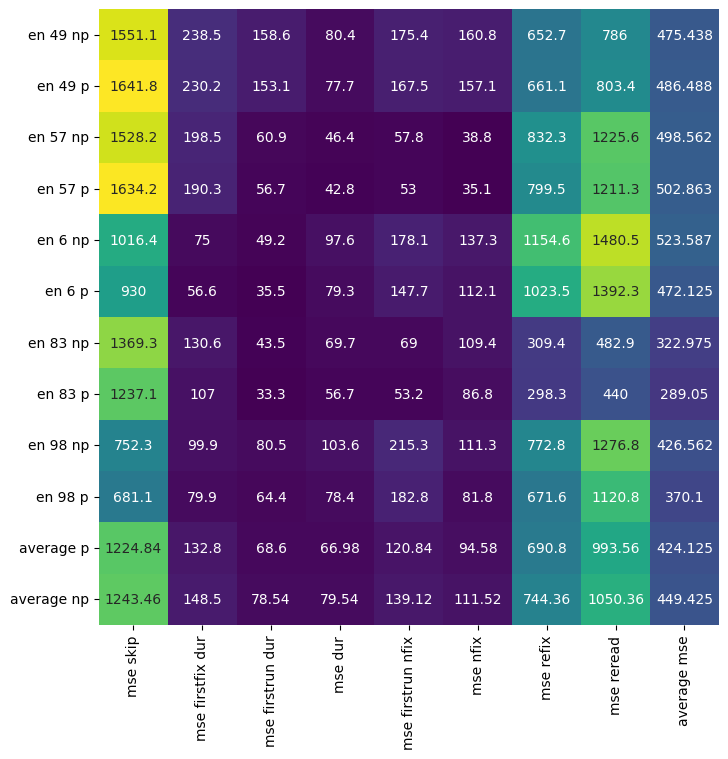

In [6]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_mse_roberta, annot=True, fmt="g", cmap='viridis', cbar=False)
plt.show()

In [7]:
df_mae_roberta = pd.DataFrame(res_mae_roberta).T
df_mae_roberta['average mae'] = df_mae_roberta.mean(axis=1)
avg_p = df_mae_roberta.apply(average_en_p_rows)
avg_np = df_mae_roberta.apply(average_en_np_rows)
df_mae_roberta.loc["average p"] = avg_p
df_mae_roberta.loc["average np"] = avg_np

In [8]:
df_mae_roberta

,acc skip,acc firstfix dur,acc firstrun dur,acc dur,acc firstrun nfix,acc nfix,acc refix,acc reread,average mae
en 49 np,79.90,90.80,92.90,95.7,91.90,92.80,91.40,89.60,90.6250
en 49 p,80.40,91.00,93.10,95.8,92.10,92.90,91.60,90.20,90.8875
en 57 np,80.20,91.50,96.10,96.9,96.20,97.20,89.70,85.20,91.6250
en 57 p,80.90,91.60,96.30,97.1,96.40,97.40,89.90,85.50,91.8875
en 6 np,86.10,95.30,96.70,95.4,92.40,94.40,85.20,80.90,90.8000
en 6 p,88.80,96.20,97.30,96.0,93.60,95.20,86.70,82.70,92.0625
en 83 np,82.00,93.40,96.60,95.8,95.20,94.40,95.70,93.80,93.3625
en 83 p,84.60,94.50,97.30,96.6,96.20,95.50,95.40,94.00,94.2625
en 98 np,89.80,94.30,95.40,95.2,91.30,94.80,89.70,83.60,91.7625
en 98 p,91.50,95.20,96.20,96.0,92.50,95.90,90.40,85.40,92.8875


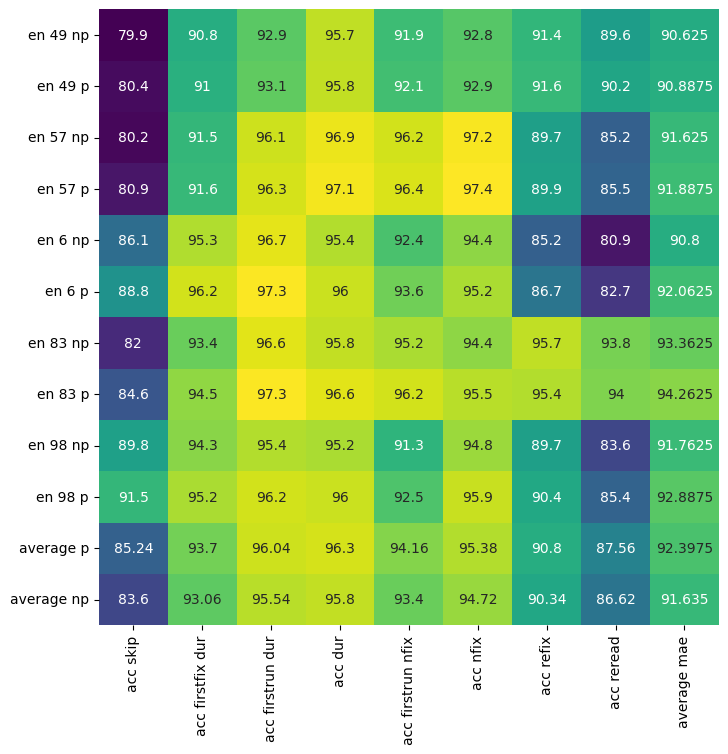

In [9]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_mae_roberta, annot=True, fmt="g", cmap='viridis', cbar=False)
plt.show()

In [10]:
process_to_present(df_mse_roberta)

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
 & mse skip & mse firstfix dur & mse firstrun dur & mse dur & mse firstrun nfix & mse nfix & mse refix & mse reread & average mse \\
en 49 np & 1551.1 & 238.5 & 158.6 & 80.4 & 175.4 & 160.8 & 652.7 & 786.0 & 475.4 \\
en 49 p & 1641.8 & 230.2 & 153.1 & 77.7 & 167.5 & 157.1 & 661.1 & 803.4 & 486.5 \\
en 57 np & 1528.2 & 198.5 & 60.9 & 46.4 & 57.8 & 38.8 & 832.3 & 1225.6 & 498.6 \\
en 57 p & 1634.2 & 190.3 & 56.7 & 42.8 & 53.0 & 35.1 & 799.5 & 1211.3 & 502.9 \\
en 6 np & 1016.4 & 75.0 & 49.2 & 97.6 & 178.1 & 137.3 & 1154.6 & 1480.5 & 523.6 \\
en 6 p & 930.0 & 56.6 & 35.5 & 79.3 & 147.7 & 112.1 & 1023.5 & 1392.3 & 472.1 \\
en 83 np & 1369.3 & 130.6 & 43.5 & 69.7 & 69.0 & 109.4 & 309.4 & 482.9 & 323.0 \\
en 83 p & 1237.1 & 107.0 & 33.3 & 56.7 & 53.2 & 86.8 & 298.3 & 440.0 & 289.0 \\
en 98 np & 752.3 & 99.9 & 80.5 & 103.6 & 215.3 & 111.3 & 772.8 & 1276.8 & 426.6 \\
en 98 p & 681.1 & 79.9 & 64.4 & 78.4 

In [11]:
process_to_present(df_mae_roberta)

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
 & acc skip & acc firstfix dur & acc firstrun dur & acc dur & acc firstrun nfix & acc nfix & acc refix & acc reread & average mae \\
en 49 np & 79.9 & 90.8 & 92.9 & 95.7 & 91.9 & 92.8 & 91.4 & 89.6 & 90.6 \\
en 49 p & 80.4 & 91.0 & 93.1 & 95.8 & 92.1 & 92.9 & 91.6 & 90.2 & 90.9 \\
en 57 np & 80.2 & 91.5 & 96.1 & 96.9 & 96.2 & 97.2 & 89.7 & 85.2 & 91.6 \\
en 57 p & 80.9 & 91.6 & 96.3 & 97.1 & 96.4 & 97.4 & 89.9 & 85.5 & 91.9 \\
en 6 np & 86.1 & 95.3 & 96.7 & 95.4 & 92.4 & 94.4 & 85.2 & 80.9 & 90.8 \\
en 6 p & 88.8 & 96.2 & 97.3 & 96.0 & 93.6 & 95.2 & 86.7 & 82.7 & 92.1 \\
en 83 np & 82.0 & 93.4 & 96.6 & 95.8 & 95.2 & 94.4 & 95.7 & 93.8 & 93.4 \\
en 83 p & 84.6 & 94.5 & 97.3 & 96.6 & 96.2 & 95.5 & 95.4 & 94.0 & 94.3 \\
en 98 np & 89.8 & 94.3 & 95.4 & 95.2 & 91.3 & 94.8 & 89.7 & 83.6 & 91.8 \\
en 98 p & 91.5 & 95.2 & 96.2 & 96.0 & 92.5 & 95.9 & 90.4 & 85.4 & 92.9 \\
average p & 85.2 & 93.7 & 96.0 & 

## CAMEM Results

In [12]:
df_mse_camem = pd.DataFrame(res_mse_camem).T
df_mse_camem['average mse'] = df_mse_camem.mean(axis=1)
avg_p = df_mse_camem.apply(average_it_p_rows)
avg_np = df_mse_camem.apply(average_it_np_rows)
df_mse_camem.loc["average p"] = avg_p
df_mse_camem.loc["average np"] = avg_np

In [13]:
df_mse_camem

,mse skip,mse firstfix dur,mse firstrun dur,mse dur,mse firstrun nfix,mse nfix,mse refix,mse reread,average mse
it 1 np,804.00,74.80,45.00,25.10,36.40,31.50,1021.2,1131.10,396.1375
it 1 p,872.40,80.20,43.30,24.40,34.50,30.60,1055.4,1172.50,414.1625
it 26 np,847.60,80.40,12.50,18.60,11.50,17.00,763.1,769.40,315.0125
it 26 p,1040.80,84.00,10.80,16.50,9.00,15.80,736.0,806.80,339.9625
it 38 np,728.10,183.00,114.00,132.70,119.00,184.70,873.3,1829.70,520.5625
it 38 p,817.60,202.90,122.10,140.00,126.30,196.50,892.9,2016.70,564.3750
it 43 np,1206.30,173.00,78.10,125.10,172.10,123.70,458.6,704.10,380.1250
it 43 p,1330.70,205.90,86.90,136.80,199.30,134.10,454.9,710.00,407.3250
it 44 np,1018.20,200.40,119.30,87.60,136.80,97.20,803.3,1316.00,472.3500
it 44 p,1120.60,219.60,125.60,89.30,143.50,100.00,817.3,1413.80,503.7125


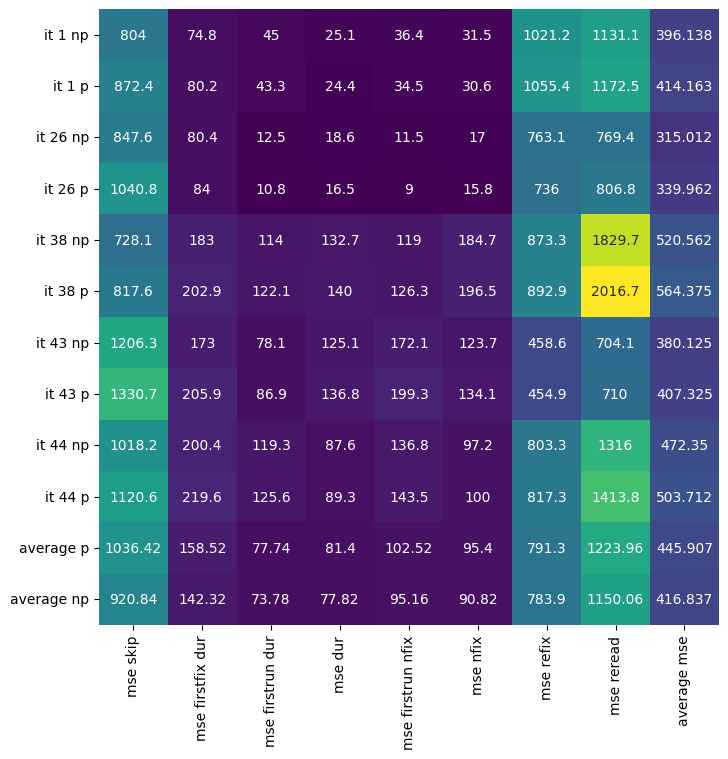

In [14]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_mse_camem, annot=True, fmt="g", cmap='viridis', cbar=False)
plt.show()

In [15]:
df_mae_camem = pd.DataFrame(res_mae_camem).T
df_mae_camem['average mae'] = df_mae_camem.mean(axis=1)
avg_p = df_mae_camem.apply(average_it_p_rows)
avg_np = df_mae_camem.apply(average_it_np_rows)
df_mae_camem.loc["average p"] = avg_p
df_mae_camem.loc["average np"] = avg_np

In [16]:
df_mae_camem

,acc skip,acc firstfix dur,acc firstrun dur,acc dur,acc firstrun nfix,acc nfix,acc refix,acc reread,average mae
it 1 np,89.40,95.7,97.2,98.3,97.40,98.20,87.40,85.60,93.6500
it 1 p,89.90,95.4,97.2,98.3,97.40,98.30,87.50,85.80,93.7250
it 26 np,88.90,95.5,98.6,98.4,98.90,98.40,90.50,90.20,94.9250
it 26 p,88.30,95.3,98.7,98.4,98.90,98.40,91.00,90.20,94.9000
it 38 np,89.70,92.6,94.5,94.8,94.00,93.70,88.80,77.00,90.6375
it 38 p,90.40,92.1,94.3,94.6,93.80,93.40,89.30,76.90,90.6000
it 43 np,84.50,92.9,95.8,94.7,92.90,94.60,94.10,91.30,92.6000
it 43 p,84.60,92.3,95.5,94.5,92.40,94.30,94.10,91.60,92.4125
it 44 np,86.70,92.3,94.4,96.3,93.70,95.80,89.80,83.50,91.5625
it 44 p,87.20,91.9,94.3,96.2,93.50,95.70,89.90,83.70,91.5500


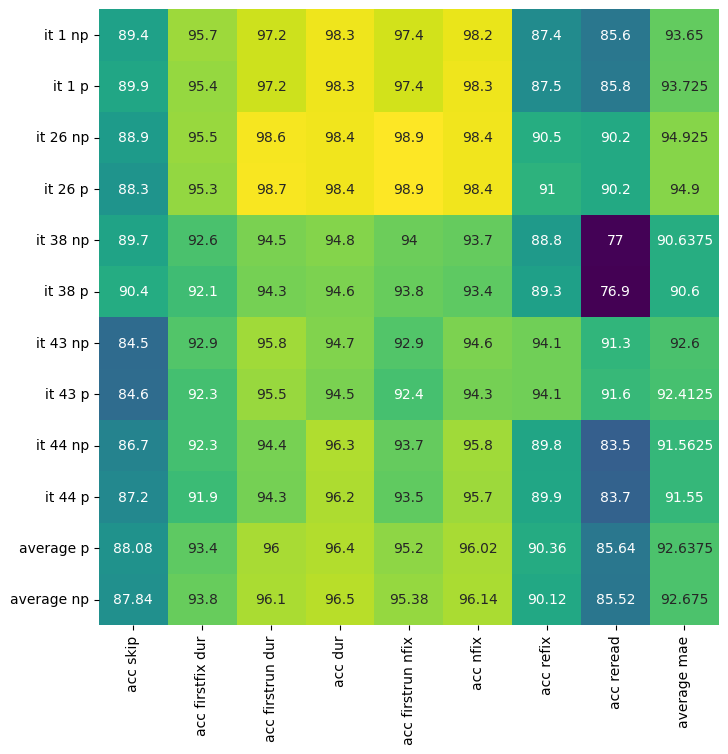

In [17]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_mae_camem, annot=True, fmt="g", cmap='viridis', cbar=False)
plt.show()

In [18]:
process_to_present(df_mse_camem)

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
 & mse skip & mse firstfix dur & mse firstrun dur & mse dur & mse firstrun nfix & mse nfix & mse refix & mse reread & average mse \\
it 1 np & 804.0 & 74.8 & 45.0 & 25.1 & 36.4 & 31.5 & 1021.2 & 1131.1 & 396.1 \\
it 1 p & 872.4 & 80.2 & 43.3 & 24.4 & 34.5 & 30.6 & 1055.4 & 1172.5 & 414.2 \\
it 26 np & 847.6 & 80.4 & 12.5 & 18.6 & 11.5 & 17.0 & 763.1 & 769.4 & 315.0 \\
it 26 p & 1040.8 & 84.0 & 10.8 & 16.5 & 9.0 & 15.8 & 736.0 & 806.8 & 340.0 \\
it 38 np & 728.1 & 183.0 & 114.0 & 132.7 & 119.0 & 184.7 & 873.3 & 1829.7 & 520.6 \\
it 38 p & 817.6 & 202.9 & 122.1 & 140.0 & 126.3 & 196.5 & 892.9 & 2016.7 & 564.4 \\
it 43 np & 1206.3 & 173.0 & 78.1 & 125.1 & 172.1 & 123.7 & 458.6 & 704.1 & 380.1 \\
it 43 p & 1330.7 & 205.9 & 86.9 & 136.8 & 199.3 & 134.1 & 454.9 & 710.0 & 407.3 \\
it 44 np & 1018.2 & 200.4 & 119.3 & 87.6 & 136.8 & 97.2 & 803.3 & 1316.0 & 472.4 \\
it 44 p & 1120.6 & 219.6 & 125.6 & 89.3 

In [19]:
process_to_present(df_mae_camem)

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
 & acc skip & acc firstfix dur & acc firstrun dur & acc dur & acc firstrun nfix & acc nfix & acc refix & acc reread & average mae \\
it 1 np & 89.4 & 95.7 & 97.2 & 98.3 & 97.4 & 98.2 & 87.4 & 85.6 & 93.7 \\
it 1 p & 89.9 & 95.4 & 97.2 & 98.3 & 97.4 & 98.3 & 87.5 & 85.8 & 93.7 \\
it 26 np & 88.9 & 95.5 & 98.6 & 98.4 & 98.9 & 98.4 & 90.5 & 90.2 & 94.9 \\
it 26 p & 88.3 & 95.3 & 98.7 & 98.4 & 98.9 & 98.4 & 91.0 & 90.2 & 94.9 \\
it 38 np & 89.7 & 92.6 & 94.5 & 94.8 & 94.0 & 93.7 & 88.8 & 77.0 & 90.6 \\
it 38 p & 90.4 & 92.1 & 94.3 & 94.6 & 93.8 & 93.4 & 89.3 & 76.9 & 90.6 \\
it 43 np & 84.5 & 92.9 & 95.8 & 94.7 & 92.9 & 94.6 & 94.1 & 91.3 & 92.6 \\
it 43 p & 84.6 & 92.3 & 95.5 & 94.5 & 92.4 & 94.3 & 94.1 & 91.6 & 92.4 \\
it 44 np & 86.7 & 92.3 & 94.4 & 96.3 & 93.7 & 95.8 & 89.8 & 83.5 & 91.6 \\
it 44 p & 87.2 & 91.9 & 94.3 & 96.2 & 93.5 & 95.7 & 89.9 & 83.7 & 91.6 \\
average p & 88.1 & 93.4 & 96.0 & 

## XLM Results

In [20]:
df_mse_xlm = pd.DataFrame(res_mse_xlm).T
df_mse_xlm['average mse'] = df_mse_xlm.mean(axis=1)
avg_p_en = df_mse_xlm.apply(average_en_p_rows)
avg_np_en = df_mse_xlm.apply(average_en_np_rows)
avg_p_it = df_mse_xlm.apply(average_it_p_rows)
avg_np_it = df_mse_xlm.apply(average_it_np_rows)
df_mse_xlm.loc["en average p"] = avg_p_en
df_mse_xlm.loc["en average np"] = avg_np_en
df_mse_xlm.loc["it average p"] = avg_p_it
df_mse_xlm.loc["it average np"] = avg_np_it

In [21]:
df_mse_xlm

,mse skip,mse firstfix dur,mse firstrun dur,mse dur,mse firstrun nfix,mse nfix,mse refix,mse reread,average mse
en 49 np,1309.80,205.70,134.00,68.10,148.00,136.60,555.30,663.60,402.6375
en 49 p,1354.30,202.00,130.50,63.50,144.90,131.70,552.60,655.30,404.3500
en 57 np,1270.80,167.70,50.80,38.10,48.10,32.00,703.80,1025.70,417.1250
en 57 p,1337.50,158.30,47.10,35.80,43.90,29.60,683.50,1016.60,419.0375
en 6 np,862.30,63.60,40.20,80.70,150.80,113.20,956.20,1229.40,437.0500
en 6 p,963.90,55.10,32.50,60.70,125.90,85.50,885.70,1190.40,424.9625
en 83 np,1145.30,109.00,35.80,58.20,57.70,92.20,260.90,404.10,270.4000
en 83 p,1244.20,105.80,31.70,53.20,51.60,85.10,256.50,418.00,280.7625
en 98 np,625.50,85.00,66.70,85.90,183.20,92.40,646.50,1061.60,355.8500
en 98 p,748.40,70.90,55.00,66.00,154.60,68.10,581.80,976.20,340.1250


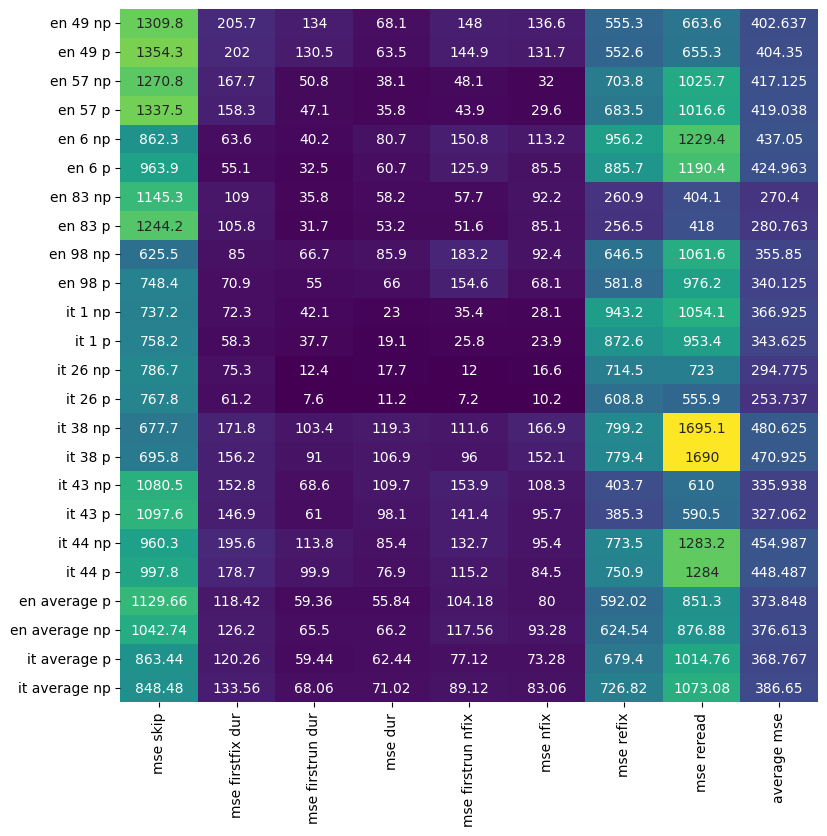

In [22]:
plt.figure(figsize=(9, 9))
sns.heatmap(df_mse_xlm, annot=True, fmt="g", cmap='viridis', cbar=False)
plt.show()

In [23]:
process_to_present(df_mse_xlm)

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
 & mse skip & mse firstfix dur & mse firstrun dur & mse dur & mse firstrun nfix & mse nfix & mse refix & mse reread & average mse \\
en 49 np & 1309.8 & 205.7 & 134.0 & 68.1 & 148.0 & 136.6 & 555.3 & 663.6 & 402.6 \\
en 49 p & 1354.3 & 202.0 & 130.5 & 63.5 & 144.9 & 131.7 & 552.6 & 655.3 & 404.4 \\
en 57 np & 1270.8 & 167.7 & 50.8 & 38.1 & 48.1 & 32.0 & 703.8 & 1025.7 & 417.1 \\
en 57 p & 1337.5 & 158.3 & 47.1 & 35.8 & 43.9 & 29.6 & 683.5 & 1016.6 & 419.0 \\
en 6 np & 862.3 & 63.6 & 40.2 & 80.7 & 150.8 & 113.2 & 956.2 & 1229.4 & 437.1 \\
en 6 p & 963.9 & 55.1 & 32.5 & 60.7 & 125.9 & 85.5 & 885.7 & 1190.4 & 425.0 \\
en 83 np & 1145.3 & 109.0 & 35.8 & 58.2 & 57.7 & 92.2 & 260.9 & 404.1 & 270.4 \\
en 83 p & 1244.2 & 105.8 & 31.7 & 53.2 & 51.6 & 85.1 & 256.5 & 418.0 & 280.8 \\
en 98 np & 625.5 & 85.0 & 66.7 & 85.9 & 183.2 & 92.4 & 646.5 & 1061.6 & 355.8 \\
en 98 p & 748.4 & 70.9 & 55.0 & 66.0 & 154.6

In [24]:
df_mae_xlm = pd.DataFrame(res_mae_xlm).T
df_mae_xlm['average mae'] = df_mae_xlm.mean(axis=1)
avg_p_en = df_mae_xlm.apply(average_en_p_rows)
avg_np_en = df_mae_xlm.apply(average_en_np_rows)
avg_p_it = df_mae_xlm.apply(average_it_p_rows)
avg_np_it = df_mae_xlm.apply(average_it_np_rows)
df_mae_xlm.loc["en average p"] = avg_p_en
df_mae_xlm.loc["en average np"] = avg_np_en
df_mae_xlm.loc["it average p"] = avg_p_it
df_mae_xlm.loc["it average np"] = avg_np_it

In [25]:
df_mae_xlm

,acc skip,acc firstfix dur,acc firstrun dur,acc dur,acc firstrun nfix,acc nfix,acc refix,acc reread,average mae
en 49 np,83.20,92.20,94.10,96.40,93.20,94.00,92.70,91.20,92.1250
en 49 p,83.50,92.30,94.10,96.50,93.30,94.10,92.60,91.20,92.2000
en 57 np,83.40,92.80,96.70,97.40,96.80,97.60,91.30,87.60,92.9500
en 57 p,84.10,93.10,96.90,97.50,97.00,97.80,91.40,88.00,93.2250
en 6 np,88.50,96.10,97.30,96.20,93.60,95.40,87.70,84.20,92.3750
en 6 p,88.50,96.40,97.60,96.60,94.30,95.90,88.10,84.90,92.7875
en 83 np,84.90,94.50,97.10,96.50,96.00,95.30,96.40,94.70,94.4250
en 83 p,84.60,94.70,97.40,96.70,96.30,95.60,95.80,94.20,94.4125
en 98 np,91.60,95.20,96.20,96.00,92.70,95.70,91.50,86.40,93.1625
en 98 p,90.90,95.60,96.60,96.50,93.20,96.40,91.50,87.10,93.4750


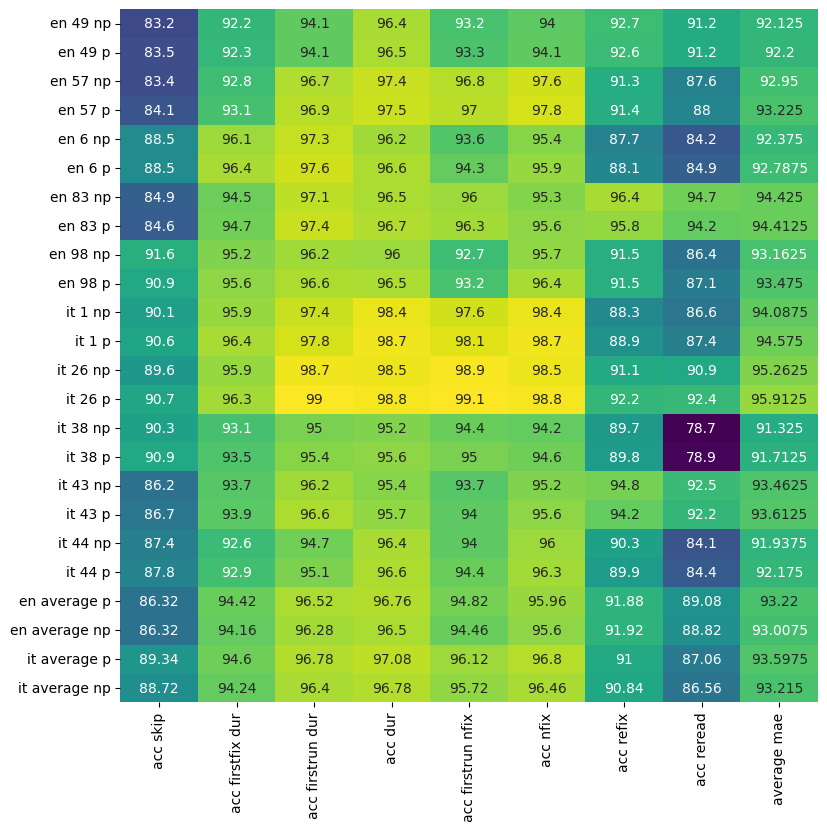

In [26]:
plt.figure(figsize=(9, 9))
sns.heatmap(df_mae_xlm, annot=True, fmt="g", cmap='viridis', cbar=False)
plt.show()

In [27]:
process_to_present(df_mae_xlm)

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
 & acc skip & acc firstfix dur & acc firstrun dur & acc dur & acc firstrun nfix & acc nfix & acc refix & acc reread & average mae \\
en 49 np & 83.2 & 92.2 & 94.1 & 96.4 & 93.2 & 94.0 & 92.7 & 91.2 & 92.1 \\
en 49 p & 83.5 & 92.3 & 94.1 & 96.5 & 93.3 & 94.1 & 92.6 & 91.2 & 92.2 \\
en 57 np & 83.4 & 92.8 & 96.7 & 97.4 & 96.8 & 97.6 & 91.3 & 87.6 & 92.9 \\
en 57 p & 84.1 & 93.1 & 96.9 & 97.5 & 97.0 & 97.8 & 91.4 & 88.0 & 93.2 \\
en 6 np & 88.5 & 96.1 & 97.3 & 96.2 & 93.6 & 95.4 & 87.7 & 84.2 & 92.4 \\
en 6 p & 88.5 & 96.4 & 97.6 & 96.6 & 94.3 & 95.9 & 88.1 & 84.9 & 92.8 \\
en 83 np & 84.9 & 94.5 & 97.1 & 96.5 & 96.0 & 95.3 & 96.4 & 94.7 & 94.4 \\
en 83 p & 84.6 & 94.7 & 97.4 & 96.7 & 96.3 & 95.6 & 95.8 & 94.2 & 94.4 \\
en 98 np & 91.6 & 95.2 & 96.2 & 96.0 & 92.7 & 95.7 & 91.5 & 86.4 & 93.2 \\
en 98 p & 90.9 & 95.6 & 96.6 & 96.5 & 93.2 & 96.4 & 91.5 & 87.1 & 93.5 \\
it 1 np & 90.1 & 95.9 & 97.4 & 98